# AIML CA1 Assignment (Part B)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import time

import warnings
warnings.filterwarnings('ignore')

# 0. How is your prediction task defined? And what is the meaning of the output variable?


This prediction task is defined as predicting the hopsital cost in US hospitals based on information such as ID, Age, Gender, BMI, etc.

The meaning of the output variable, which is Cost, is how much the patient has to pay for the hospital fee.

After some background research, I have an idea of what each feature means.
- ID: The ID of each row to indicate that each row is unique as two rows may have the exact same data but are from different patients.
- Age: The age of the patient.
- Gender: The gender of the patient.
- BMI: The Body Mass Index of the patient. Derived from taking the weight / height$^2$.
- Smoker: Whether the patient smokes or not.
- Region: Region in the US where the hospital is located at.
- Cost: The hospital fee for each patient.

### Outline of the task:
1. Load data
2. Remove duplicative data (if any)
3. Remove missing data (if any)
4. Remove outliers (if any)
5. Impute missing data (if any)
6. Scale data
7. Test which models favor which type of data (scale/unscaled & with outliers/without outliers)
8. Hypertune models
9. Select best model by score
10. Comapre with dummy baseline

# 1. Load Data

In [2]:
df = pd.read_csv('D:\\randal\\SP\\Year 1 Sem 2\\ST1511 AI & Machine Learning\\CA1\\CA1-Dataset\\CA1-Regression-Dataset.csv')
df

,ID,Age,Gender,BMI,Smoker,Region,Cost ($)
0,1,19,female,27.900,yes,southwest,16884.92400
1,2,18,male,33.770,no,southeast,1725.55230
2,3,28,male,33.000,no,southeast,4449.46200
3,4,33,male,22.705,no,northwest,21984.47061
4,5,32,male,28.880,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,1334,50,male,30.970,no,northwest,10600.54830
1334,1335,18,female,31.920,no,northeast,2205.98080
1335,1336,18,female,36.850,no,southeast,1629.83350
1336,1337,21,female,25.800,no,southwest,2007.94500


# 2. Data Preprocessing

## A. Analyse Missing/Duplicative Data

### 1. Check for duplicative data

In [3]:
df[df.duplicated(keep=False)]

,ID,Age,Gender,BMI,Smoker,Region,Cost ($)


Since there is no results, there are no duplicative data

### 2. Check for missing data

<Axes: >

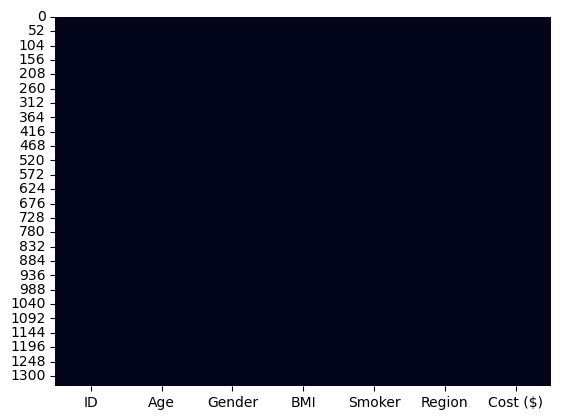

In [4]:
# view missing data
sns.heatmap(df.isnull(), cbar=False)

In [5]:
# view number of missing values
df.isnull().sum().sort_values()

ID          0
Age         0
Gender      0
BMI         0
Smoker      0
Region      0
Cost ($)    0
dtype: int64

Since there are 0 isnull values from the output above, there is no missing values

## B. Create Dummy Variables For Categorical Data

As Regression models can only work with continuous data, we will create dummy variables for each categorical feature to convert them from categorical data to continuous data

In [6]:
# create dummy variables
df = pd.get_dummies(df, dtype=int, drop_first=True)
df

,ID,Age,BMI,Cost ($),Gender_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest
0,1,19,27.900,16884.92400,0,1,0,0,1
1,2,18,33.770,1725.55230,1,0,0,1,0
2,3,28,33.000,4449.46200,1,0,0,1,0
3,4,33,22.705,21984.47061,1,0,1,0,0
4,5,32,28.880,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,1334,50,30.970,10600.54830,1,0,1,0,0
1334,1335,18,31.920,2205.98080,0,0,0,0,0
1335,1336,18,36.850,1629.83350,0,0,0,1,0
1336,1337,21,25.800,2007.94500,0,0,0,0,1


## C. Visualise Distribution of Continuous Features 

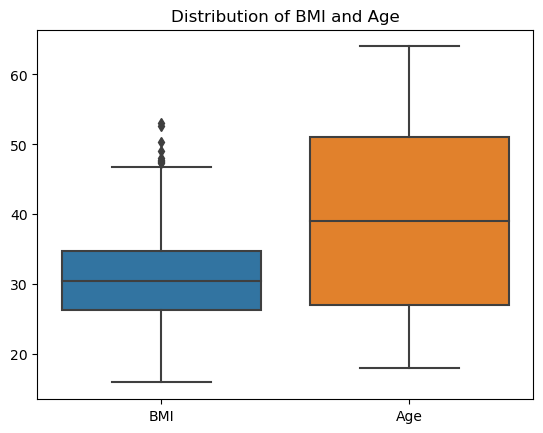

In [7]:
# plot boxplot of BMI and Age
sns.boxplot(df[['BMI', 'Age']])
plt.title('Distribution of BMI and Age')
plt.show()

From the boxplot above, BMI has quite a few outliers while Age is quite balanced

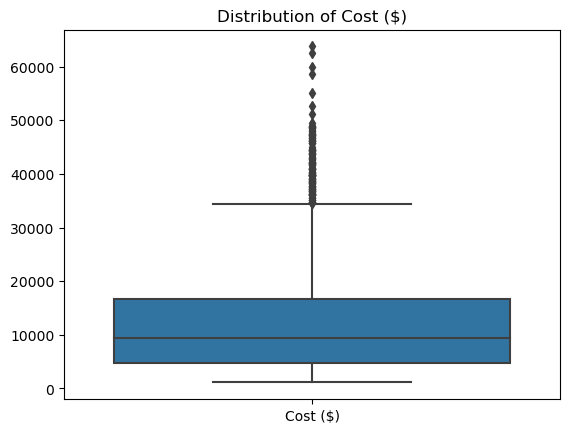

In [8]:
# plot boxplot of Cost
sns.boxplot(df[['Cost ($)']])
plt.title('Distribution of Cost ($)')
plt.show()

From the boxplot above, Cost has quite a lot of outliers

However, we cannot be 100% sure that these outliers will negatively impact the models' performances as these high costs may be because the patient seeked more complex treatments or have rare diseases. Hence, we decided not to remove them

## D. Scale Continuous Features Using Standardisation

As the ranges of the data vary and we do not want one feature to influence the model more than the others, we will scale our data using standardisation but only for features with continuous data

We will also remove the ID column as it probably will not influence the models' performances and the purpose of the ID column is to make sure that if there is more than one patient with the exact same features as another patient, it will not be treated as duplicative data

In [9]:
# train test split
X = df.drop(['Cost ($)', 'ID'], axis=1)
y = df['Cost ($)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data by standardisation but only with continuous data
scaler = StandardScaler()
X_train[['Age', 'BMI']] = scaler.fit_transform(X_train[['Age', 'BMI']])
X_test[['Age', 'BMI']] = scaler.transform(X_test[['Age', 'BMI']])

print(f'First 5 rows of X_train:\n{X_train.head()}')
print()
print(f'First 5 rows of X_test:\n{X_test.head()}')

First 5 rows of X_train:
           Age       BMI  Gender_male  Smoker_yes  Region_northwest  \
560   0.472227 -1.756525            0           0                 1   
1285  0.543313 -1.033082            0           0                 0   
1142  0.898745 -0.943687            0           0                 0   
969  -0.025379  0.622393            0           0                 0   
486   1.040918 -1.504893            0           0                 1   

      Region_southeast  Region_southwest  
560                  0                 0  
1285                 0                 0  
1142                 1                 0  
969                  1                 0  
486                  0                 0  

First 5 rows of X_test:
           Age       BMI  Gender_male  Smoker_yes  Region_northwest  \
764   0.401140 -0.891539            0           0                 0   
887  -0.238638 -0.089461            0           0                 1   
890   1.751782 -0.608453            0           1   

From the output above, we can verify that the scaling has worked by observing that the values of Age and BMI have changed

## E. Selecting Important Features Using LassoCV

### 1. Hypertune LassoCV Alpha Paramater

In [10]:
# initialise all the values of alpha that we want to test
alphas = np.arange(0, 100)

kf = KFold(n_splits=5)  # split the data into equal proportions

# perform LassoCV
lasso = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred)
r2_lasso = r2_score(y_test, y_pred)

print(f'Best Alpha: {lasso.alpha_}')
print(f'MSE Score: {mse_lasso}')
print(f'R-Squared Score: {r2_lasso}')
print(f'Coefficients: {lasso.coef_}')

Best Alpha: 78
MSE Score: 34659809.5688692
R-Squared Score: 0.7767465844272885
Coefficients: [ 3569.60535303  1902.91104636     0.         23185.06500553
     0.            -0.           -53.23413927]


In [11]:
X_train.columns

Index(['Age', 'BMI', 'Gender_male', 'Smoker_yes', 'Region_northwest',
       'Region_southeast', 'Region_southwest'],
      dtype='object')

From the output above, we can see that the LassoCV model has identified features that are deemed unnecessary to getting the predicted price. However, I do think that Region_northwest and Region_southeast will influence the cost as some regions may have lesser hospitals or some locations only provide some niche treatments which will affect the price. I also think that the gender will affect the price as different genders have different types of diseases which will affect the price. Hence, I will have one dataset with the dropped features and one without and compare them to see which one yields the best results for the model

### 2. Drop Features

In [12]:
X_train_dropped = X_train.drop(['Gender_male', 'Region_northwest', 'Region_southeast'], axis=1)
X_test_dropped = X_test.drop(['Gender_male', 'Region_northwest', 'Region_southeast'], axis=1)

print(f'First 5 rows of X_train_dropped:\n{X_train_dropped.head()}')
print()
print(f'First 5 rows of X_test_dropped:\n{X_test_dropped.head()}')

First 5 rows of X_train_dropped:
           Age       BMI  Smoker_yes  Region_southwest
560   0.472227 -1.756525           0                 0
1285  0.543313 -1.033082           0                 0
1142  0.898745 -0.943687           0                 0
969  -0.025379  0.622393           0                 0
486   1.040918 -1.504893           0                 0

First 5 rows of X_test_dropped:
           Age       BMI  Smoker_yes  Region_southwest
764   0.401140 -0.891539           0                 0
887  -0.238638 -0.089461           0                 0
890   1.751782 -0.608453           1                 0
1293  0.472227 -0.797177           0                 0
259  -1.447107  0.225079           1                 0


# 3. Model Selection

## A. Hypertuning Models' Params

### 1. Select Models To Use

Regression Models:
1. DecisionTreeRegressor
2. RandomForestRegressor
3. GradientBoostingRegressor
4. LassoCV
5. RidgeCV
6. SVR
7. KNeighborsRegressor

I didn't include LinearRegressor as LassoCV and RidgeCV are already LinearRegressors

### 2. Select Parameters To Test

In [13]:
dtr_params = {    
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  # measures quality of split
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # min number of samples per leaf before split ends
    "min_weight_fraction_leaf": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],  # min number of samples required to be at a leaf node
    "max_features": ["auto", "log2", "sqrt", None],
    "max_leaf_nodes": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90]
}

rfr_params = {
    'n_estimators': [5, 20, 50, 75, 100], # number of trees in the random forest
    'max_features': ['auto', 'sqrt', 'log2', None], # number of features in consideration at every split
    'max_depth': [int(x) for x in np.linspace(10, 120, 12)], # maximum number of levels allowed in each decision tree
    'min_samples_split': [2, 6, 10], # minimum sample number to split a node
    'min_samples_leaf': [1, 3, 4], # minimum sample number that can be stored in a leaf node
    'bootstrap': [True, False] # method used to sample data points
}

gbr_params = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [1, 2, 4],
    'subsample': [0.5, 0.75, 1]
}

alphas = np.arange(0.1, 101, 0.1)  # for LassoCV and RidgeCV

svr_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.arange(1, 100, 2)  # regularisation strength
}

knn_params = {
    'n_neighbors': np.arange(1, 101, 2),
    'weights': ['uniform', 'distance']
}

### 3. Hypertune Hyperparameters Using GridSearchCV And RandomizedSearchCV

We used KFold instead of StratifiedKFold as StratifiedKFold is designed for categorical data and not continuous data

We will first split the for loop into 3 conditions:
1. Model is either DecisionTreeRegressor or RandomForestRegressor or GradientBoostingRegressor

    This is because there is quite alot of parameters for these 3 models that we want to hypertune. Hence, using RandomizedSearchCV would be faster than doing GridSearchCV to find all the possible combinations.

2. Model is either LassoCV or RidgeCV

    We are separating this as the code for these two models are different as they perform their own cross-validation and hence we cannot use RandomizedSearchCV or GridSearchCV to hypertune them. 

3. Remaining Models

    We will perform GridSearchCV on these models as they do not have that many parameters to hypertune and can afford to find the best parameters out of all the possible combinations.

In [14]:
# selected regression models and their respective params
models_params = {
    'DecisionTreeRegressor': (DecisionTreeRegressor, dtr_params),
    'RandomForestRegressor': (RandomForestRegressor, rfr_params),
    'GradientBoostingRegressor': (GradientBoostingRegressor, gbr_params),
    'LassoCV': (LassoCV, alphas),
    'RidgeCV': (RidgeCV, alphas),
    'SVR': (SVR, svr_params),
    'KNN': (KNeighborsRegressor, knn_params)
}

kf = KFold(n_splits=5)  # split the data into equal proportions

for model in models_params:
    if model == 'DecisionTreeRegressor' or model == 'RandomForestRegressor' or model == 'GradientBoostingTree':
        # perform radnomizedsearch on with dropped features
        random_search = RandomizedSearchCV(
            models_params[model][0](), models_params[model][1], n_jobs=-1, cv=kf, n_iter=200, random_state=41
        )
        random_search.fit(X_train_dropped, y_train)

        print(f'Best {model} With Dropping Features Parameters: {random_search.best_params_}') 
        print(f'Best {model} With Dropping Features Best R-Squared Score: {random_search.best_score_}')
        print()

        # perform radnomizedsearch on without dropped features
        random_search = RandomizedSearchCV(
            models_params[model][0](), models_params[model][1], n_jobs=-1, cv=kf, n_iter=200, random_state=41
        )
        random_search.fit(X_train, y_train)

        print(f'Best {model} Without Dropping Features Parameters: {random_search.best_params_}') 
        print(f'Best {model} Without Dropping Features Best R-Squared Score: {random_search.best_score_}')
        print()
    elif model == 'LassoCV' or model == 'RidgeCV':  # without RandomizedSearchCV or GridSearchCV as LassoCV and RidgeCV already cross-validates by themselves
        # with dropped features
        cv_model = LassoCV(alphas=alphas, cv=5)
        cv_model.fit(X_train_dropped, y_train)
        pred = cv_model.predict(X_test_dropped)

        print(f'Best {model} With Dropping Features Parameters: {cv_model.alpha_}') 
        print(f'Best {model} With Dropping Features Best R-Squared Score: {r2_score(y_test, pred)}')
        print()
        
        # without dropped features
        cv_model = LassoCV(alphas=alphas, cv=5)
        cv_model.fit(X_train, y_train)
        pred = cv_model.predict(X_test)

        print(f'Best {model} Without Dropping Features Parameters: {cv_model.alpha_}') 
        print(f'Best {model} Without Dropping Features Best R-Squared Score: {r2_score(y_test, pred)}')
        print()
    else:
        # perform gridsearch on with dropped features
        grid_search = GridSearchCV(models_params[model][0](), models_params[model][1], n_jobs=-1, cv=kf)
        grid_search.fit(X_train_dropped, y_train)

        print(f'Best {model} With Dropping Features Parameters: {grid_search.best_params_}') 
        print(f'Best {model} With Dropping Features Best R-Squared Score: {grid_search.best_score_}')
        print()

        # perform gridsearch on without dropped features
        grid_search = GridSearchCV(models_params[model][0](), models_params[model][1], n_jobs=-1, cv=kf)
        grid_search.fit(X_train, y_train)

        print(f'Best {model} Without Dropping Features Parameters: {grid_search.best_params_}') 
        print(f'Best {model} Without Dropping Features Best R-Squared Score: {grid_search.best_score_}')
        print()

Best DecisionTreeRegressor With Dropping Features Parameters: {'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 9, 'max_leaf_nodes': 70, 'max_features': None, 'max_depth': 12, 'criterion': 'poisson'}
Best DecisionTreeRegressor With Dropping Features Best R-Squared Score: 0.7866312380895816

Best DecisionTreeRegressor Without Dropping Features Parameters: {'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 10, 'max_leaf_nodes': 40, 'max_features': None, 'max_depth': 5, 'criterion': 'squared_error'}
Best DecisionTreeRegressor Without Dropping Features Best R-Squared Score: 0.7866312380895816

Best RandomForestRegressor With Dropping Features Parameters: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
Best RandomForestRegressor With Dropping Features Best R-Squared Score: 0.8402537320154512

Best RandomForestRegressor Without Dropping Features Parameters: {'n_estimators': 100, 'min_samples_split': 10, '

Although R-squared measures the proportion of total variance, it does not measure the errors that the model makes. Hence, we will use cross_val_score to get the Mean Absolute Error (MAE) and Mean Squared Error (MSE). For the scoring of cross_val_score for MAE and MSE, we use neg_mean_absolute_error and neg_mean_squared_error as the lower the error score, the better the model is. However, cross_val_score will take the best score (highest), which is the opposite of what we want. Hence, we will have the MAE and MSE scores to be negative and times it by -1 afterwards to make it a positive number for easier interpretation

For simplicity, we will only be taking models with a R-Squared score of 0.8 and above

In [15]:
hypertuned_models = {
    'DecisionTreeRegressor_with_dropping': DecisionTreeRegressor(
        min_weight_fraction_leaf=0.1,
        min_samples_leaf=5,
        max_leaf_nodes=50,
        max_features=None,
        max_depth=5,
        criterion='poisson'
    ),
    'DecisionTreeRegressor_without_dropping': DecisionTreeRegressor(
        min_weight_fraction_leaf=0.1,
        min_samples_leaf=3,
        max_leaf_nodes=20,
        max_features=None,
        max_depth=5,
        criterion='squared_error'
    ),
    'RandomForestRegressor_with_dropping': RandomForestRegressor(
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=4,
        max_features='log2',
        max_depth=100,
        bootstrap=True
    ),
    'RandomForestRegressor_without_dropping': RandomForestRegressor(
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features=None,
        max_depth=90,
        bootstrap=True
    ),
    'GradientBoostingRegressor_with_dropping': GradientBoostingRegressor(
        learning_rate=0.01,
        max_depth=2,
        n_estimators=500,
        subsample=0.75
    ),
    'GradientBoostingRegressor_without_dropping': GradientBoostingRegressor(
        learning_rate=0.01,
        max_depth=2,
        n_estimators=1000,
        subsample=1,
    ),
    'KNN_with_dropped': KNeighborsRegressor(
        n_neighbors=5,
        weights='uniform'
    )
}

kf = KFold(n_splits=5)  # split the data into equal proportions

for model in hypertuned_models:
    if '_with_dropping' in model:  # selects all the models that require the data to have dropped features
        dropped_model_r2 = cross_val_score(
            hypertuned_models[model], X_train_dropped, y_train, cv=kf, scoring='r2', n_jobs=-1
        )
        dropped_model_mae = cross_val_score(
            hypertuned_models[model], X_train_dropped, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1
        ) * -1  # show a positive error score
        dropped_model_mse = cross_val_score(
            hypertuned_models[model], X_train_dropped, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1
        ) * -1  # show a positive error score
        
        print(f'{model} R-squared Score: {np.mean(dropped_model_r2)}')
        print(f'{model} Mean Abosolute Error Score: {np.mean(dropped_model_mae)}')
        print(f'{model} Mean Squared Error Score: {np.mean(dropped_model_mse)}')
        print()
    else:  # models that require the data to have ALL the features
        model_r2 = cross_val_score(
            hypertuned_models[model], X_train, y_train, cv=kf, scoring='r2', n_jobs=-1
        )
        model_mae = cross_val_score(
            hypertuned_models[model], X_train, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1
        ) * -1  # show a positive error score
        model_mse = cross_val_score(
            hypertuned_models[model], X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1
        ) * -1  # show a positive error score
        
        print(f'{model} R-squared Score: {np.mean(model_r2)}')
        print(f'{model} Mean Abosolute Error Score: {np.mean(model_mae)}')
        print(f'{model} Mean Squared Error Score: {np.mean(model_mse)}')
        print()

DecisionTreeRegressor_with_dropping R-squared Score: 0.7866312380895815
DecisionTreeRegressor_with_dropping Mean Abosolute Error Score: 3381.266693862411
DecisionTreeRegressor_with_dropping Mean Squared Error Score: 30882336.186781265

DecisionTreeRegressor_without_dropping R-squared Score: 0.7866312380895815
DecisionTreeRegressor_without_dropping Mean Abosolute Error Score: 3381.266693862411
DecisionTreeRegressor_without_dropping Mean Squared Error Score: 30882336.186781265

RandomForestRegressor_with_dropping R-squared Score: 0.8383108990096758
RandomForestRegressor_with_dropping Mean Abosolute Error Score: 2748.9071404321166
RandomForestRegressor_with_dropping Mean Squared Error Score: 22700608.818158023

RandomForestRegressor_without_dropping R-squared Score: 0.8363875579353293
RandomForestRegressor_without_dropping Mean Abosolute Error Score: 2775.654699367535
RandomForestRegressor_without_dropping Mean Squared Error Score: 23227531.5504045

GradientBoostingRegressor_with_dropping

Since GradientBoostingRegressor without the dropped features perform the best (highest R-Squared score and lowest MAE and MSE score), we shall use it as our final model

## B. Train And Score Best Model With Test Data

In [16]:
# train-test model with best hypertuned parameters
best_gbr = GradientBoostingRegressor(learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=1, random_state=20)
best_gbr.fit(X_train, y_train)
best_gbr_y_pred = best_gbr.predict(X_test)
best_gbr_r2 = r2_score(y_test, best_gbr_y_pred)
best_gbr_mae = mean_absolute_error(y_test, best_gbr_y_pred)
best_gbr_mse = mean_squared_error(y_test, best_gbr_y_pred)

print(f'The R-squared score for the best GradientBoostingRegressor model without dropping features is: {round(best_gbr_r2, 2)}')
print(f'The MAE score for the best GradientBoostingRegressor model without dropping features is: {round(best_gbr_mae, 2)}')
print(f'The MSE score for the best GradientBoostingRegressor model without dropping features is: {round(best_gbr_mse, 2)}')

The R-squared score for the best GradientBoostingRegressor model without dropping features is: 0.87
The MAE score for the best GradientBoostingRegressor model without dropping features is: 2549.69
The MSE score for the best GradientBoostingRegressor model without dropping features is: 19777399.33


## C. Compare With Dummy Baseline Model

We will also fit the dummy baseline model with the same type of data (without dropping features) so that it is a fair comparison with the best GradientBoostingRegressor model

### 1. Train and Score Dummy Baseline Model

In [17]:
# train-test dummy baseline model
dummy_model = DummyRegressor(constant=99, strategy='constant')
dummy_model.fit(X_train, y_train)
dummy_model_y_pred = dummy_model.predict(X_test)
dummy_model_r2 = r2_score(y_test, dummy_model_y_pred)
dummy_model_mae = mean_absolute_error(y_test, dummy_model_y_pred)
dummy_model_mse = mean_squared_error(y_test, dummy_model_y_pred)
print(f'The R-squared score for the best dummy_model without dropping features is: {round(dummy_model_r2, 2)}')
print(f'The MAE score for the best dummy_model without dropping features is: {round(dummy_model_mae, 2)}')
print(f'The MSE score for the best dummy_model without dropping features is: {round(dummy_model_mse, 2)}')

The R-squared score for the best dummy_model without dropping features is: -1.07
The MAE score for the best dummy_model without dropping features is: 12869.32
The MSE score for the best dummy_model without dropping features is: 320868053.16


### 2. Compare Between Best GradientBoostingRegressor Model and Dummy Baseline Model

In [18]:
print(f'R-Squared Score increased by: {round(best_gbr_r2 - dummy_model_r2, 2)}')

R-Squared Score increased by: 1.94


### 3. Determine Which Features The GradientBoostingRegressor Model Considers Important

The GradientBoostingRegressor model has a property called feature_importances_ which is an array of the features' importance which we can use to determine which features the model considers important

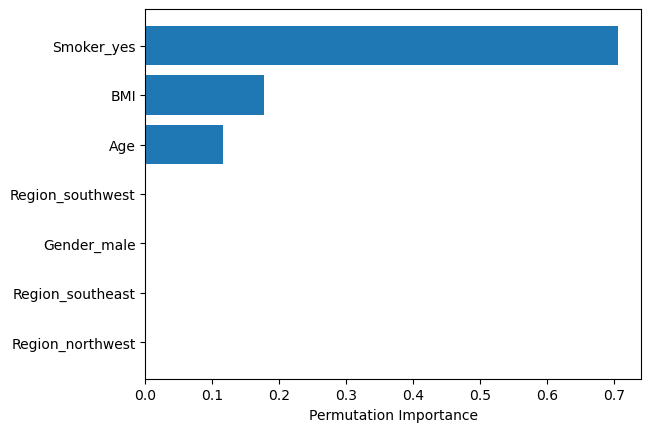

In [19]:
importances = best_gbr.feature_importances_
indices = np.argsort(importances)

features = np.array(list(df.drop(['Cost ($)', 'ID'], axis=1).columns))

plt.barh(features[indices], importances[indices])  # plot a horizontal bar plot for all the scores and its respective feature names
plt.xlabel('Permutation Importance')

plt.show()

From the horizontal bar plot shown above, we can tell that the top 3 features that are deemed important by the GradientBoostingRegressor model are Smoker_yes (whether the patient is a smoker), BMI and Age in determining the hospital fee for each patient

# 4. Conclusion

To summarise the process of training this Regression model:

## A. Did you process the features in any way?

Yes, I first created dummy_varibles for the categorical features (Region, Smoker and Gender). Then, I scaled the data. Finally, I used LassoCV to determine which features are deemed important to it and created a spearate dataset.

## B. How did you select which learning algorithms to use?

I chose LassoCV, RidgeCV, GradientBoostingRegressor, DecisionTreeRegressor, RandomForestRegressor, KNeighborsRegressor and SVR as some were popular and some were found in the lecture slides.

## C. Did you try to tune the hyperparameters of the learning algorithm, and in that case how?

Yes, I first googled and found parameters and their respective value ranges for some of the models. For those which were not included in the website, I went to the documentation to see what parameters were there for the remaining models and randomly chose values for those parameters.

Then, I tuned the hyperparameters by using either RandomizedSearchCV or GridSearchCV (depending on how many parameters are needed to hypertune) which will split the training data into n_folds and select one of the folds as the validation set. It will then train the model using the remaining n-1 folds of data and use the validation set to test and score. It will repeat this for n times and for every possible combination of parameters.

I hypertuned each model with two sets of data, one with dropping the features selected by the LassoCV model and one without, and got their respective R-Squared, MSE and MAE scores for each set of data.

## D. How do you evaluate the quality of your system?

I used the R-Squared score, together with MAE and MSE scores as the main evaluation of the quality of my best chosen model as R-Squared score as it indicates how well the regression model captures the variability in the data while MAE and MSE scores indicates the accuracy of the predicted values compared to the actual values.

## E. How well does your system compare to a dummy baseline?

The R-Squared score of the GradientBoostingRegressor model was 1.94 higher than the dummy baseline model.

## F. Is it possible to say something about which features the model considers important?

The top 3 features that are deemed important by the GradientBoostingRegressor model are Smoker_yes (whether the patient is a smoker), BMI and Age in determining the hospital fee for each patient which are determined by GradientBoostingRegressor.feature_importances_